In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr


In [5]:
#Load the data GHCN-D daily temperature records from Plant City (Station USC00087205)

df = pd.read_csv("s3://noaa-ghcn-pds/csv/by_station/USC00087205.csv", storage_options={"anon": True},  # passed to `s3fs.S3FileSystem`
dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'}, parse_dates=['DATE']).set_index('DATE')

C:\Users\jclabarcena\AppData\Local\Temp\ipykernel_14608\3402706459.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("s3://noaa-ghcn-pds/csv/by_station/USC00087205.csv", storage_options={"anon": True},  # passed to `s3fs.S3FileSystem`


In [6]:
print(df.head())

                     ID ELEMENT  DATA_VALUE M_FLAG Q_FLAG S_FLAG  OBS_TIME
DATE                                                                      
1892-09-01  USC00087205    TMAX         322    NaN    NaN      6       NaN
1892-09-02  USC00087205    TMAX         317    NaN    NaN      6       NaN
1892-09-03  USC00087205    TMAX         317    NaN    NaN      6       NaN
1892-09-04  USC00087205    TMAX         322    NaN    NaN      6       NaN
1892-09-05  USC00087205    TMAX         333    NaN    NaN      6       NaN


In [7]:
print(df['ELEMENT'].unique())

['TMAX' 'TMIN' 'PRCP' 'TOBS' 'SNOW' 'SNWD' 'WT16' 'WT08' 'WT11' 'DAPR'
 'MDPR' 'WT14' 'WT03' 'WT01' 'WT06' 'WT04']


In [ ]:
#Note that the values are scaled integers.  To get values in degrees C, divide the values by 10.

In [ ]:
#Strawberries are planted around October 1 and ready for harvest by the end of January. What is the mean risk of frost and freeze, defined as the mean number of days per month over the period 1991-2020 that the temperature has been observed to be less than or equal to 32 and 28 degrees Fahrenheit, respectively, that might damage the plants for each month during the October - January period?

In [8]:
# Mean number of frost (<=32°F) and freeze (<=28°F) days per month (Oct-Jan, 1991-2020)
# 32°F = 0°C, 28°F ≈ -2.22°C
df = df[df["ELEMENT"].isin(["TMAX", "TMIN"])]
df["year"] = df.index.year
df["month"] = df.index.month

df = df[(df.index.year >= 1991) & (df.index.year <= 2020)]

# Convert tenths °C to °C; replace GHCN missing sentinel (-9999) with NaN.
df["VALUE_C"] = pd.to_numeric(df["DATA_VALUE"], errors="coerce").replace(-9999, np.nan) / 10.0


In [9]:
#Filter for months Oct-Jan
oct_jan = [10, 11, 12, 1]
df_oct_jan = df[df.index.month.isin(oct_jan)]

In [10]:
#Mean number of frost (<=32°F) and freeze (<=28°F) days per month (Oct-Jan, 1991-2020)
# 32°F = 0°C, 28°F ≈ -2.22°C
frost_days = df_oct_jan[df_oct_jan["VALUE_C"] <= 0].groupby(["year", "month"]).size()
freeze_days = df_oct_jan[df_oct_jan["VALUE_C"] <= -2.22].groupby(["year", "month"]).size()

# Calculate mean days per month across all years
mean_frost = frost_days.groupby("month").mean()
mean_freeze = freeze_days.groupby("month").mean()

# Results
result = pd.DataFrame({"Mean Frost Days (<=32°F)": mean_frost, "Mean Freeze Days (<=28°F)": mean_freeze})
result = result.reindex([10, 11, 12, 1])
result.index = ["October", "November", "December", "January"]
result

,Mean Frost Days (<=32°F),Mean Freeze Days (<=28°F)
October,NaN,NaN
November,1.000000,NaN
December,2.571429,2.500000
January,2.800000,1.666667


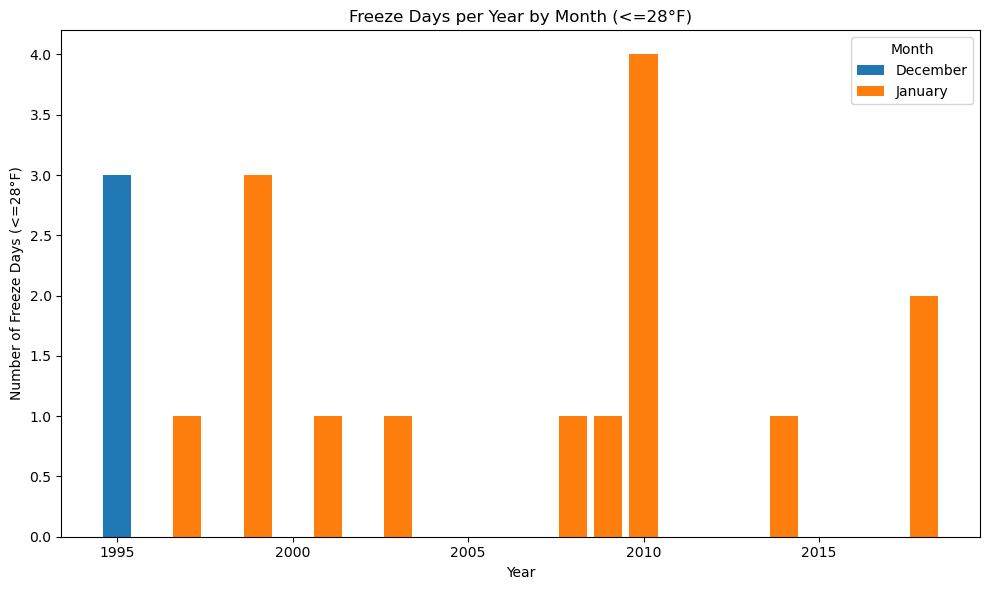

In [11]:
#Plot freeze_days
#Convert freeze_days Series to DataFrame for plotting
freeze_df = freeze_days.reset_index()
freeze_df.columns = ['year', 'month', 'count']
#Map month numbers to names
month_map = {1: 'January', 10: 'October', 11: 'November', 12: 'December'}
freeze_df['month_name'] = freeze_df['month'].map(month_map)

#Create bar plot
plt.figure(figsize=(10,6))
for m, group in freeze_df.groupby('month_name'):
    plt.bar(group['year'], group['count'], label=m)
plt.xlabel('Year')
plt.ylabel('Number of Freeze Days (<=28°F)')
plt.title('Freeze Days per Year by Month (<=28°F)')
plt.legend(title='Month')
plt.tight_layout()
plt.show()

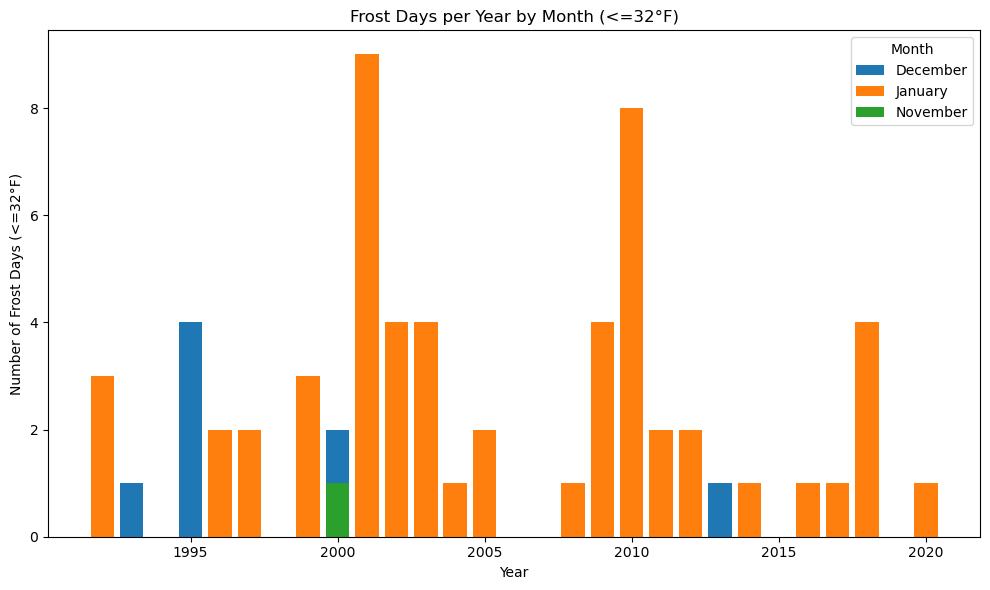

In [20]:
#Same plot for frost_days
#Convert freeze_days Series to DataFrame for plotting
frost_df = frost_days.reset_index()
frost_df.columns = ['year', 'month', 'count']
#Map month numbers to names
month_map = {1: 'January', 10: 'October', 11: 'November', 12: 'December'}
frost_df['month_name'] = frost_df['month'].map(month_map)

#Create bar plot
plt.figure(figsize=(10,6))
for m, group in frost_df.groupby('month_name'):
    plt.bar(group['year'], group['count'], label=m)
plt.xlabel('Year')
plt.ylabel('Number of Frost Days (<=32°F)')
plt.title('Frost Days per Year by Month (<=32°F)')
plt.legend(title='Month')
plt.tight_layout()
plt.show()

In [ ]:
#There is a greater risk of frost days (<=32°F) than freeze days (<=28°F) during the October to January period in Plant City, FL. The plots show that frost days occur more frequently compared to freeze days. This indicates that while temperatures may drop below freezing, they are more likely to hover just above the freeze threshold, posing a significant risk to strawberry crops during these months. January is the month with the highest average number of frost and freeze days, followed by December and November. October has the lowest risk among the four months considered.

In [ ]:
 #2. To begin to explore the seasonal to sub-seasonal prediction of freeze events at this site, using code you adapt from Module 4, we're going to try to relate these cold events to the El Nino Southern Oscillation (ENSO).  You have a hypothesis that ENSO is related to seasonal prediction of freeze events, but you don't know which region to choose for calculating your anomalies.  The problem is that there are many ENSO indicies that represent forcing across the eastern and central Pacific: which SST forcing region is most related to cold conditions in central Florida?

#NOAA CPC has calculated mean SSTs and anomalies in each of these 4 regions (cpc.ncep.noaa.gov/data/indices/sstoi.indicesLinks to an external site.). Using the temperature anomalies computed in the file, determine which ENSO index (NINO1+2, NINO3, NINO4, and NINO3.4) is best correlated (i.e., has the highest absolute value of Pearson's correlation coefficient) with the number of days per month < 28 degrees F.  (25 points)

In [22]:
#Reading ENSO data from NOAA CPC
url = "https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices"

colnames = [
    "year", "month",
    "nino12", "nino12_anom",
    "nino3",  "nino3_anom",
    "nino4",  "nino4_anom",
    "nino34", "nino34_anom",
]

df = pd.read_csv(
    url,
    sep=r"\s+",
    skiprows=1,          # skip the header line in the file
    names=colnames,
    engine="python",
)

# handy time index
df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))

print(df.head())


   year  month  nino12  nino12_anom  nino3  nino3_anom  nino4  nino4_anom  \
0  1982      1   24.28        -0.24  25.84        0.17  28.01       -0.21   
1  1982      2   25.38        -0.72  26.26       -0.11  27.99       -0.11   
2  1982      3   25.22        -1.38  26.92       -0.25  28.18       -0.05   
3  1982      4   24.57        -1.16  27.52       -0.05  28.61        0.10   
4  1982      5   24.00        -0.62  27.70        0.49  29.19        0.40   

   nino34  nino34_anom       date  
0   26.65         0.08 1982-01-01  
1   26.54        -0.20 1982-02-01  
2   27.09        -0.14 1982-03-01  
3   27.83         0.02 1982-04-01  
4   28.37         0.49 1982-05-01  


In [ ]:
#Getting the freeze day count data per month

freeze_df = freeze_days.reset_index()
freeze_df.columns = ['year', 'month', 'count']

In [26]:
print(freeze_df.head())

   year  month  count
0  1995     12      3
1  1997      1      1
2  1999      1      3
3  2001      1      1
4  2003      1      1


In [ ]:
# Filter ENSO dataframe to match years and months in freeze_df and keep the freeze count
enso_match = df.merge(freeze_df[['year', 'month', 'count']], on=['year', 'month'], how='inner')
print(enso_match.tail())

    year  month  nino12  nino12_anom  nino3  nino3_anom  nino4  nino4_anom  \
6   2009      1   24.36        -0.16  25.32       -0.35  27.38       -0.84   
7   2010      1   24.52         0.00  26.73        1.06  29.39        1.16   
8   2010     12   21.64        -1.20  23.98       -1.29  27.31       -1.14   
9   2014      1   24.71         0.19  25.47       -0.20  27.91       -0.32   
10  2018      1   23.78        -0.74  24.59       -1.09  28.02       -0.20   

    nino34  nino34_anom       date  count  
6    25.76        -0.80 2009-01-01      1  
7    28.10         1.53 2010-01-01      4  
8    25.44        -1.21 2010-12-01      2  
9    26.07        -0.49 2014-01-01      1  
10   25.87        -0.70 2018-01-01      2  


In [41]:
print(len(enso_match))

11


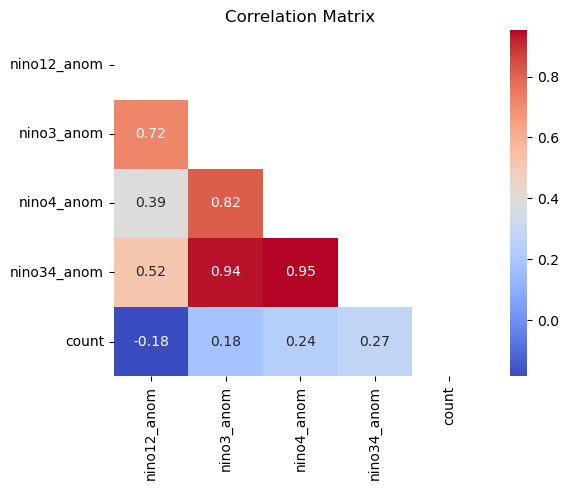

In [ ]:
#Correlation between the variables.
#Choose the columns to include in the correlation matrix
selected_columns = ['nino12_anom', 'nino3_anom', 'nino4_anom', 'nino34_anom', 'count']

corr = enso_match[selected_columns].corr(method='pearson')

#Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(6, 5))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
#Highest absolute correlation coefficient for freeze days in Central Florida is with El Niño 3.4 region SST anomalies (nino34_anom). The value is not very high, indicating a weak correlation (0.27)